In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
import analysis.fid as fid
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import time

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [3]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [4]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time: %s, %f" % (c, t))
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

def class_to_class_index_tensor(c, classes):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

In [5]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

os.environ["MODEL_DIR"] = os.path.join(models_base_path, "mnist_continuous_class_extension_multistep")

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

In [6]:
figure_dir = "/gstore/home/tsenga5/branched_diffusion/figures/mnist_class_extension_multistep_2"

In [7]:
# Define the original branches
classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

input_shape = (1, 28, 28)

In [8]:
# Define the SDE
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

### Introducing a new digit class

In [9]:
def limit_branch_defs(old_branch_defs, new_classes):
    # First, remove all branches which do not include one of the classes,
    # and remove all references to classes which don't belong
    temp_branch_defs = []
    new_classes = set(new_classes)
    for bd in old_branch_defs:
        if not set(bd[0]) & new_classes:
            continue
        temp_branch_defs.append((tuple(sorted(set(bd[0]) & new_classes)), bd[1], bd[2]))
    
    # Now combine branches with the same class-definition into the same branch
    new_branch_defs = []
    for class_tup in list(set(bd[0] for bd in temp_branch_defs)):
        class_bds = sorted([bd for bd in temp_branch_defs if bd[0] == class_tup], key=(lambda bd: bd[1]))
        if len(class_bds) > 1:
            for i in range(len(class_bds) - 1):
                assert abs(class_bds[i][2] - class_bds[i + 1][1]) < 1e-10
            new_branch_defs.append((class_tup, class_bds[0][1], class_bds[-1][2]))
        else:
            new_branch_defs.append(class_bds[0])
    return new_branch_defs

In [10]:
def create_data_loader(classes):
    dataset = torchvision.datasets.MNIST(
        "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
    )

    # Limit classes
    inds = np.isin(dataset.targets, classes)
    dataset.data = dataset.data[inds]
    dataset.targets = dataset.targets[inds]
    
    return torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [11]:
# Define the branches
classes_049 = [0, 4, 9]
branch_defs_049 = limit_branch_defs(branch_defs, classes_049)
# This one needs to be specifically ordered due to a pretrained model
branch_defs_049 = [
    [bd for bd in branch_defs_049 if bd[0] == class_tup][0]
    for class_tup in [(0, 4, 9), (0,), (4, 9), (4,), (9,)]
]

classes_0497 = [0, 4, 9, 7]
branch_defs_0497 = limit_branch_defs(branch_defs, classes_0497)
branch_defs_0497[1] = ((4, 9), 0.35235235235235235, 0.4)
branch_defs_0497[4] = ((7,), 0, 0.4)
branch_defs_0497[5] = ((4, 7, 9), 0.4, 0.4854854854854855)

classes_04971 = [0, 4, 9, 7, 1]
branch_defs_04971 = limit_branch_defs(branch_defs, classes_04971)
branch_defs_04971[1] = ((4, 9), 0.35235235235235235, 0.4)
branch_defs_04971[5] = ((7,), 0, 0.4)
branch_defs_04971[6] = ((4, 7, 9), 0.4, 0.44744744744744747)

classes_049712 = [0, 4, 9, 7, 1, 2]
branch_defs_049712 = limit_branch_defs(branch_defs, classes_049712)
branch_defs_049712[4] = ((4, 9), 0.35235235235235235, 0.4)
branch_defs_049712[7] = ((7,), 0, 0.4)
branch_defs_049712[8] = ((4, 7, 9), 0.4, 0.44744744744744747)

data_loader_7 = create_data_loader([7])
data_loader_1 = create_data_loader([1])
data_loader_2 = create_data_loader([2])
data_loader_049 = create_data_loader([0, 4, 9])
data_loader_049712 = create_data_loader([0, 4, 9, 7, 1, 2])

### Class extension on branched model

In [12]:
def map_branch_def(branch_def, target_branch_defs):
    """
    Given a particular branch definition (i.e. a triplet), and a
    list of branch definitions, attempts to match that branch
    definition to the corresponding entry in the list. This
    mapping is based on whether or not the branch would need to be
    retrained. The query `branch_def` is matched to a target within
    `branch_defs` if the target's class indices are all present in
    the query, and the query time is a sub-interval of the target
    time.
    Arguments:
        `branch_def`: a branch definition (i.e. triplet of class index
            tuple, start time, and end time)
        `target_branch_defs`: a list of branch definitions
    Returns the index of the matched branch definition in `branch_defs`,
    or -1 if there is no suitable match found.
    """
    for i, target_branch_def in enumerate(target_branch_defs):
        if set(branch_def[0]).issuperset(set(target_branch_def[0])) \
            and branch_def[1] >= target_branch_def[1] \
            and branch_def[2] <= target_branch_def[2]:
            return i
    return -1

In [13]:
def generate_branched_samples(model, classes, branch_defs, plot=True, save_stem=None):
    all_samples = {}
    for class_to_sample in classes:
        print("Sampling class: %s" % class_to_sample)
        samples = generate.generate_continuous_branched_samples(
            model, sde, class_to_sample,
            lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
            sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
        ).cpu().numpy()
        if plot:
            plot_mnist_digits(samples, grid_size=(10, 1), title=None)
            if save_stem:
                plt.savefig("%s_%s.svg" % (save_stem, class_to_sample), format="svg")
            plt.show()
        all_samples[class_to_sample] = samples
    return all_samples

In [14]:
def create_extended_branched_model(old_model, old_branch_defs, new_branch_defs, new_branch_source_index=-1):
    # Create new model and copy over parameters
    new_model = image_unet.MultitaskMNISTUNetTimeConcat(
        len(new_branch_defs), t_limit=t_limit
    ).to(DEVICE)

    # Figure out which branches should be copied over to which ones
    branch_map_inds = [
        map_branch_def(bd, old_branch_defs) for bd in new_branch_defs
    ]

    # For each submodule, copy over the weights
    # Careful: this assumes a particular kind of architecture!
    for module_name, module_list in old_model.named_children():
        if len(module_list) == 1:
            new_model.get_submodule(module_name).load_state_dict(
                module_list.state_dict()
            )
        elif len(module_list) == len(old_branch_defs):
            target_module_list = new_model.get_submodule(module_name)
            for target_i, source_i in enumerate(branch_map_inds):
                if source_i != -1:
                    target_module_list[target_i].load_state_dict(
                        module_list[source_i].state_dict()
                    )
                else:
                    # Copy over some other branch for a warm start
                    # We'll manually set it for now (TODO)
                    source_i = new_branch_source_index
                    target_module_list[target_i].load_state_dict(
                        module_list[source_i].state_dict()
                    )
        else:
            raise ValueError("Found module list of length %d" % len(module_list))
    return new_model, branch_map_inds

In [15]:
def fine_tune_branched_model(model, branch_defs, data_loader, t_limit, num_epochs=50):
    # Freeze all shared layers of the model
    for module_name, module_list in model.named_children():
        if len(module_list) == 1:
            for p in module_list[0].parameters():
                p.requires_grad = False
        elif len(module_list) != len(branch_defs):
            raise ValueError("Found module list of length %d" % len(module_list))

    # Train
    train_continuous_model.train_ex.run(
        "train_branched_model",
        config_updates={
            "model": model,
            "sde": sde,
            "data_loader": data_loader,
            "class_time_to_branch_index": lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
            "num_epochs": num_epochs,
            "learning_rate": 0.001,
            "t_limit": t_limit,
            "loss_weighting_type": "empirical_norm"
        }
    )

In [16]:
branched_model_049 = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat,
    os.path.join(models_base_path, "mnist_continuous_class_extension/mnist_continuous_branched_3classes/1/last_ckpt.pth")
).to(DEVICE)

Sampling class: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 29.74it/s]


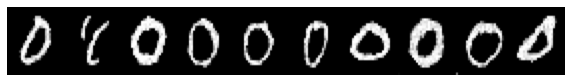

Sampling class: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.08it/s]


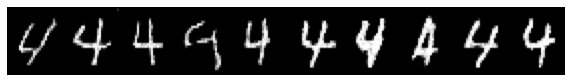

Sampling class: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.03it/s]


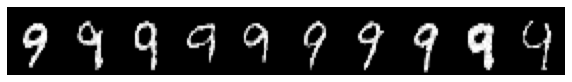

In [17]:
branched_samples_049 = generate_branched_samples(
    branched_model_049, classes_049, branch_defs_049,
    save_stem=os.path.join(figure_dir, "branched_049_digits")
)

In [18]:
branched_model_0497, branch_map_inds_049_0497 = create_extended_branched_model(
    branched_model_049, branch_defs_049, branch_defs_0497
)

fine_tune_branched_model(
    branched_model_0497, branch_defs_0497, data_loader_7,
    [bd[2] for bd in branch_defs_0497 if bd[0] == (7,)][0], 100
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "1"
Loss: 50.87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.09it/s]


Epoch 1 average Loss: 56.98


Loss: 59.87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.51it/s]


Epoch 2 average Loss: 51.87


Loss: 42.80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.45it/s]


Epoch 3 average Loss: 54.27


Loss: 48.35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.20it/s]


Epoch 4 average Loss: 53.21


Loss: 55.73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.53it/s]


Epoch 5 average Loss: 52.28


Loss: 61.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.06it/s]


Epoch 6 average Loss: 52.05


Loss: 54.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.48it/s]


Epoch 7 average Loss: 52.44


Loss: 49.47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.40it/s]


Epoch 8 average Loss: 51.21


Loss: 51.79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.42it/s]


Epoch 9 average Loss: 50.86


Loss: 40.93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.49it/s]


Epoch 10 average Loss: 51.00


Loss: 44.06: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.32it/s]


Epoch 11 average Loss: 51.48


Loss: 42.38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.45it/s]


Epoch 12 average Loss: 51.42


Loss: 56.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.39it/s]


Epoch 13 average Loss: 51.44


Loss: 39.32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.38it/s]


Epoch 14 average Loss: 51.02


Loss: 48.58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.35it/s]


Epoch 15 average Loss: 50.08


Loss: 47.11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.55it/s]


Epoch 16 average Loss: 49.83


Loss: 61.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.34it/s]


Epoch 17 average Loss: 49.56


Loss: 59.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.41it/s]


Epoch 18 average Loss: 50.36


Loss: 44.22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.28it/s]


Epoch 19 average Loss: 50.46


Loss: 47.41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.37it/s]


Epoch 20 average Loss: 49.92


Loss: 44.56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.28it/s]


Epoch 21 average Loss: 50.85


Loss: 53.79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.34it/s]


Epoch 22 average Loss: 50.08


Loss: 41.67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.33it/s]


Epoch 23 average Loss: 50.13


Loss: 51.75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.33it/s]


Epoch 24 average Loss: 50.03


Loss: 51.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.52it/s]


Epoch 25 average Loss: 50.09


Loss: 56.31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.42it/s]


Epoch 26 average Loss: 49.06


Loss: 48.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.51it/s]


Epoch 27 average Loss: 48.15


Loss: 48.40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.43it/s]


Epoch 28 average Loss: 48.86


Loss: 44.59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.31it/s]


Epoch 29 average Loss: 49.23


Loss: 49.18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.42it/s]


Epoch 30 average Loss: 49.86


Loss: 44.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.47it/s]


Epoch 31 average Loss: 48.44


Loss: 43.30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.42it/s]


Epoch 32 average Loss: 49.01


Loss: 52.04: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.32it/s]


Epoch 33 average Loss: 48.61


Loss: 52.77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.41it/s]


Epoch 34 average Loss: 51.42


Loss: 46.35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.52it/s]


Epoch 35 average Loss: 49.18


Loss: 47.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.56it/s]


Epoch 36 average Loss: 48.90


Loss: 42.86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.37it/s]


Epoch 37 average Loss: 48.26


Loss: 38.34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.54it/s]


Epoch 38 average Loss: 47.40


Loss: 57.41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.48it/s]


Epoch 39 average Loss: 49.09


Loss: 51.85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.53it/s]


Epoch 40 average Loss: 48.98


Loss: 51.79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.42it/s]


Epoch 41 average Loss: 48.17


Loss: 45.47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.51it/s]


Epoch 42 average Loss: 48.21


Loss: 51.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.55it/s]


Epoch 43 average Loss: 47.24


Loss: 50.37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.33it/s]


Epoch 44 average Loss: 49.13


Loss: 47.60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.42it/s]


Epoch 45 average Loss: 48.54


Loss: 47.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.41it/s]


Epoch 46 average Loss: 49.49


Loss: 46.50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.39it/s]


Epoch 47 average Loss: 49.06


Loss: 57.34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.40it/s]


Epoch 48 average Loss: 49.33


Loss: 53.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.58it/s]


Epoch 49 average Loss: 49.74


Loss: 52.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.48it/s]


Epoch 50 average Loss: 47.92


Loss: 47.82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.34it/s]


Epoch 51 average Loss: 48.82


Loss: 47.72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.39it/s]


Epoch 52 average Loss: 48.63


Loss: 57.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.30it/s]


Epoch 53 average Loss: 49.04


Loss: 59.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.43it/s]


Epoch 54 average Loss: 48.88


Loss: 49.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.57it/s]


Epoch 55 average Loss: 48.13


Loss: 40.36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.45it/s]


Epoch 56 average Loss: 48.77


Loss: 47.95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.39it/s]


Epoch 57 average Loss: 48.04


Loss: 56.47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.43it/s]


Epoch 58 average Loss: 48.60


Loss: 57.42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.48it/s]


Epoch 59 average Loss: 48.23


Loss: 46.62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.32it/s]


Epoch 60 average Loss: 48.72


Loss: 43.61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.43it/s]


Epoch 61 average Loss: 49.13


Loss: 43.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.30it/s]


Epoch 62 average Loss: 48.46


Loss: 52.38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.44it/s]


Epoch 63 average Loss: 48.85


Loss: 52.27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.45it/s]


Epoch 64 average Loss: 48.29


Loss: 55.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.32it/s]


Epoch 65 average Loss: 47.90


Loss: 49.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.37it/s]


Epoch 66 average Loss: 49.14


Loss: 46.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.40it/s]


Epoch 67 average Loss: 49.00


Loss: 42.10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.16it/s]


Epoch 68 average Loss: 48.05


Loss: 48.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.40it/s]


Epoch 69 average Loss: 49.45


Loss: 48.99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.28it/s]


Epoch 70 average Loss: 49.48


Loss: 46.36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.41it/s]


Epoch 71 average Loss: 48.53


Loss: 41.78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.40it/s]


Epoch 72 average Loss: 47.91


Loss: 57.95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.30it/s]


Epoch 73 average Loss: 47.32


Loss: 52.30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.53it/s]


Epoch 74 average Loss: 48.66


Loss: 53.06: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.33it/s]


Epoch 75 average Loss: 47.11


Loss: 53.08: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.47it/s]


Epoch 76 average Loss: 47.24


Loss: 40.50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.31it/s]


Epoch 77 average Loss: 49.81


Loss: 47.96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.49it/s]


Epoch 78 average Loss: 48.23


Loss: 50.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.29it/s]


Epoch 79 average Loss: 46.51


Loss: 48.89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.22it/s]


Epoch 80 average Loss: 47.87


Loss: 38.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.55it/s]


Epoch 81 average Loss: 48.13


Loss: 46.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.25it/s]


Epoch 82 average Loss: 48.13


Loss: 44.65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.35it/s]


Epoch 83 average Loss: 46.87


Loss: 50.05: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.32it/s]


Epoch 84 average Loss: 48.17


Loss: 55.19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.41it/s]


Epoch 85 average Loss: 48.07


Loss: 49.03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.36it/s]


Epoch 86 average Loss: 47.64


Loss: 48.92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.41it/s]


Epoch 87 average Loss: 47.23


Loss: 46.58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.31it/s]


Epoch 88 average Loss: 47.38


Loss: 47.80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.53it/s]


Epoch 89 average Loss: 47.51


Loss: 43.27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.53it/s]


Epoch 90 average Loss: 46.79


Loss: 37.82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.47it/s]


Epoch 91 average Loss: 47.42


Loss: 51.32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.58it/s]


Epoch 92 average Loss: 48.57


Loss: 40.78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.26it/s]


Epoch 93 average Loss: 47.15


Loss: 59.50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.25it/s]


Epoch 94 average Loss: 46.89


Loss: 48.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.31it/s]


Epoch 95 average Loss: 48.18


Loss: 49.79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.37it/s]


Epoch 96 average Loss: 47.09


Loss: 52.17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.33it/s]


Epoch 97 average Loss: 48.32


Loss: 50.50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.31it/s]


Epoch 98 average Loss: 46.96


Loss: 41.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.49it/s]


Epoch 99 average Loss: 47.40


Loss: 43.43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.41it/s]
INFO - train - Completed after 0:06:10


Epoch 100 average Loss: 47.70


Sampling class: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.05it/s]


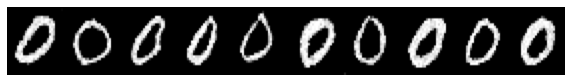

Sampling class: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.94it/s]


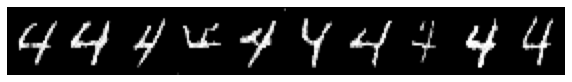

Sampling class: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.82it/s]


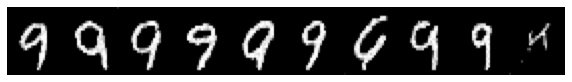

Sampling class: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.86it/s]


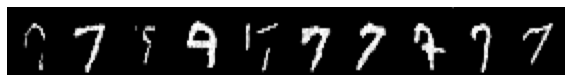

In [19]:
branched_samples_0497 = generate_branched_samples(
    branched_model_0497, classes_0497, branch_defs_0497,
    save_stem=os.path.join(figure_dir, "branched_0497_digits")
)

In [20]:
branched_model_04971, branch_map_inds_0497_04971 = create_extended_branched_model(
    branched_model_0497, branch_defs_0497, branch_defs_04971
)

fine_tune_branched_model(
    branched_model_04971, branch_defs_04971, data_loader_1,
    [bd[2] for bd in branch_defs_04971 if bd[0] == (1,)][0]
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "2"
Loss: 27.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.86it/s]


Epoch 1 average Loss: 39.11


Loss: 35.62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.86it/s]


Epoch 2 average Loss: 36.71


Loss: 29.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.91it/s]


Epoch 3 average Loss: 35.09


Loss: 38.76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.93it/s]


Epoch 4 average Loss: 34.33


Loss: 39.43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.03it/s]


Epoch 5 average Loss: 35.42


Loss: 39.74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.11it/s]


Epoch 6 average Loss: 34.13


Loss: 31.42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.11it/s]


Epoch 7 average Loss: 33.35


Loss: 28.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.95it/s]


Epoch 8 average Loss: 33.25


Loss: 29.48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.92it/s]


Epoch 9 average Loss: 33.70


Loss: 31.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.92it/s]


Epoch 10 average Loss: 33.79


Loss: 36.91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.04it/s]


Epoch 11 average Loss: 33.78


Loss: 27.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.01it/s]


Epoch 12 average Loss: 32.55


Loss: 35.42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.95it/s]


Epoch 13 average Loss: 32.99


Loss: 32.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.92it/s]


Epoch 14 average Loss: 32.55


Loss: 35.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.09it/s]


Epoch 15 average Loss: 32.09


Loss: 42.53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.13it/s]


Epoch 16 average Loss: 33.23


Loss: 39.79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.07it/s]


Epoch 17 average Loss: 32.56


Loss: 21.67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.93it/s]


Epoch 18 average Loss: 32.88


Loss: 33.89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.10it/s]


Epoch 19 average Loss: 32.85


Loss: 33.24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.12it/s]


Epoch 20 average Loss: 31.52


Loss: 26.65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.12it/s]


Epoch 21 average Loss: 32.55


Loss: 33.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.12it/s]


Epoch 22 average Loss: 32.04


Loss: 33.77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.97it/s]


Epoch 23 average Loss: 32.97


Loss: 37.51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.07it/s]


Epoch 24 average Loss: 33.54


Loss: 31.91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.18it/s]


Epoch 25 average Loss: 33.55


Loss: 42.15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.03it/s]


Epoch 26 average Loss: 31.48


Loss: 29.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.97it/s]


Epoch 27 average Loss: 33.14


Loss: 31.32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.97it/s]


Epoch 28 average Loss: 31.81


Loss: 24.05: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.10it/s]


Epoch 29 average Loss: 32.33


Loss: 46.78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.06it/s]


Epoch 30 average Loss: 32.44


Loss: 38.05: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.91it/s]


Epoch 31 average Loss: 30.56


Loss: 30.10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.99it/s]


Epoch 32 average Loss: 31.20


Loss: 26.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.02it/s]


Epoch 33 average Loss: 30.78


Loss: 23.71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.04it/s]


Epoch 34 average Loss: 33.28


Loss: 26.34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.94it/s]


Epoch 35 average Loss: 30.77


Loss: 35.24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.96it/s]


Epoch 36 average Loss: 30.78


Loss: 27.40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.90it/s]


Epoch 37 average Loss: 31.23


Loss: 34.88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.08it/s]


Epoch 38 average Loss: 30.92


Loss: 26.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.93it/s]


Epoch 39 average Loss: 31.26


Loss: 38.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.91it/s]


Epoch 40 average Loss: 32.24


Loss: 27.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.03it/s]


Epoch 41 average Loss: 31.46


Loss: 31.86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.97it/s]


Epoch 42 average Loss: 32.65


Loss: 27.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.06it/s]


Epoch 43 average Loss: 31.54


Loss: 35.31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.04it/s]


Epoch 44 average Loss: 31.19


Loss: 28.49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.06it/s]


Epoch 45 average Loss: 31.10


Loss: 37.23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.14it/s]


Epoch 46 average Loss: 32.62


Loss: 29.95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.93it/s]


Epoch 47 average Loss: 32.95


Loss: 29.61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.93it/s]


Epoch 48 average Loss: 31.62


Loss: 38.95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.82it/s]


Epoch 49 average Loss: 31.75


Loss: 30.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.90it/s]
INFO - train - Completed after 0:03:44


Epoch 50 average Loss: 30.61


Sampling class: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.94it/s]


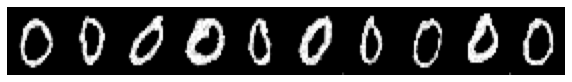

Sampling class: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.85it/s]


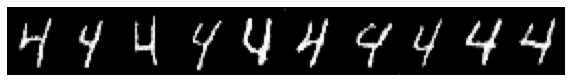

Sampling class: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.64it/s]


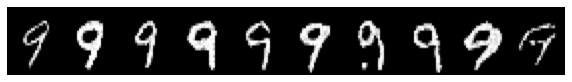

Sampling class: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.76it/s]


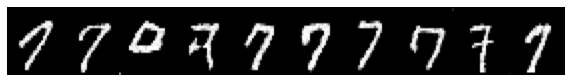

Sampling class: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.84it/s]


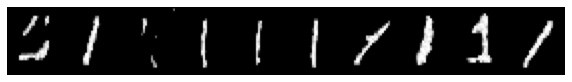

In [21]:
branched_samples_04971 = generate_branched_samples(
    branched_model_04971, classes_04971, branch_defs_04971,
    save_stem=os.path.join(figure_dir, "branched_04971_digits")
)

In [22]:
branched_model_049712, branch_map_inds_04971_049712 = create_extended_branched_model(
    branched_model_04971, branch_defs_04971, branch_defs_049712
)

fine_tune_branched_model(
    branched_model_049712, branch_defs_049712, data_loader_2,
    [bd[2] for bd in branch_defs_049712 if bd[0] == (2,)][0]
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "3"
Loss: 61.44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.52it/s]


Epoch 1 average Loss: 71.88


Loss: 72.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.71it/s]


Epoch 2 average Loss: 65.21


Loss: 60.15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.67it/s]


Epoch 3 average Loss: 62.99


Loss: 66.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.76it/s]


Epoch 4 average Loss: 64.10


Loss: 50.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.71it/s]


Epoch 5 average Loss: 64.99


Loss: 57.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.68it/s]


Epoch 6 average Loss: 64.29


Loss: 67.75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.57it/s]


Epoch 7 average Loss: 61.77


Loss: 61.72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.73it/s]


Epoch 8 average Loss: 62.65


Loss: 61.72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.68it/s]


Epoch 9 average Loss: 61.61


Loss: 50.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.59it/s]


Epoch 10 average Loss: 62.03


Loss: 60.52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.59it/s]


Epoch 11 average Loss: 60.40


Loss: 66.05: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.77it/s]


Epoch 12 average Loss: 60.97


Loss: 55.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.59it/s]


Epoch 13 average Loss: 62.10


Loss: 63.15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.62it/s]


Epoch 14 average Loss: 60.51


Loss: 60.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.55it/s]


Epoch 15 average Loss: 60.96


Loss: 65.78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.60it/s]


Epoch 16 average Loss: 60.84


Loss: 63.52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.58it/s]


Epoch 17 average Loss: 60.53


Loss: 83.18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.55it/s]


Epoch 18 average Loss: 60.85


Loss: 62.45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.67it/s]


Epoch 19 average Loss: 60.35


Loss: 50.03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.61it/s]


Epoch 20 average Loss: 58.79


Loss: 55.45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.59it/s]


Epoch 21 average Loss: 59.86


Loss: 54.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.71it/s]


Epoch 22 average Loss: 59.53


Loss: 52.73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.66it/s]


Epoch 23 average Loss: 59.48


Loss: 69.12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.62it/s]


Epoch 24 average Loss: 59.38


Loss: 60.90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.59it/s]


Epoch 25 average Loss: 59.24


Loss: 52.72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.56it/s]


Epoch 26 average Loss: 58.06


Loss: 65.86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.51it/s]


Epoch 27 average Loss: 59.62


Loss: 66.29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.59it/s]


Epoch 28 average Loss: 58.21


Loss: 54.30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.72it/s]


Epoch 29 average Loss: 59.97


Loss: 53.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.62it/s]


Epoch 30 average Loss: 59.40


Loss: 57.55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.51it/s]


Epoch 31 average Loss: 57.02


Loss: 57.41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.52it/s]


Epoch 32 average Loss: 59.31


Loss: 51.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.57it/s]


Epoch 33 average Loss: 59.42


Loss: 58.23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.56it/s]


Epoch 34 average Loss: 58.39


Loss: 57.22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.71it/s]


Epoch 35 average Loss: 59.75


Loss: 69.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.56it/s]


Epoch 36 average Loss: 59.78


Loss: 57.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.70it/s]


Epoch 37 average Loss: 59.78


Loss: 59.38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.60it/s]


Epoch 38 average Loss: 58.95


Loss: 66.61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.54it/s]


Epoch 39 average Loss: 57.06


Loss: 52.34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.64it/s]


Epoch 40 average Loss: 57.79


Loss: 47.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.62it/s]


Epoch 41 average Loss: 60.71


Loss: 55.91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.62it/s]


Epoch 42 average Loss: 57.16


Loss: 51.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.54it/s]


Epoch 43 average Loss: 57.00


Loss: 66.73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.71it/s]


Epoch 44 average Loss: 59.96


Loss: 52.95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.59it/s]


Epoch 45 average Loss: 58.58


Loss: 49.18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.51it/s]


Epoch 46 average Loss: 57.35


Loss: 56.73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.51it/s]


Epoch 47 average Loss: 57.89


Loss: 63.27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.63it/s]


Epoch 48 average Loss: 59.20


Loss: 53.74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.69it/s]


Epoch 49 average Loss: 58.55


Loss: 54.21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.64it/s]
INFO - train - Completed after 0:03:45


Epoch 50 average Loss: 58.03


Sampling class: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.80it/s]


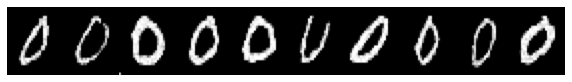

Sampling class: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.68it/s]


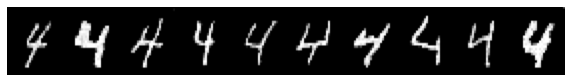

Sampling class: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.46it/s]


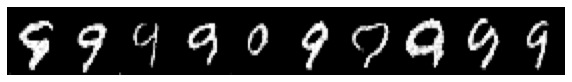

Sampling class: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.60it/s]


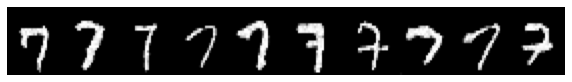

Sampling class: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.72it/s]


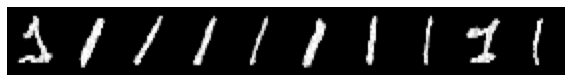

Sampling class: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.74it/s]


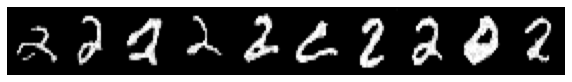

In [23]:
branched_samples_049712 = generate_branched_samples(
    branched_model_049712, classes_049712, branch_defs_049712,
    save_stem=os.path.join(figure_dir, "branched_049712_digits")
)

### Class extension in label-guided model

In [24]:
def generate_linear_samples(model, classes, plot=True, save_stem=None):
    all_samples = {}
    for class_to_sample in classes:
        print("Sampling class: %s" % class_to_sample)
        samples = generate.generate_continuous_label_guided_samples(
            model, sde, class_to_sample,
            lambda c: class_to_class_index_tensor(c, classes),
            sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
        ).cpu().numpy()
        if plot:
            plot_mnist_digits(samples, grid_size=(10, 1), title=None)
            if save_stem:
                plt.savefig("%s_%s.svg" % (save_stem, class_to_sample), format="svg")
            plt.show()
        all_samples[class_to_sample] = samples
    return all_samples

In [25]:
def fine_tune_linear_model(model, classes, data_loader, num_epochs=50):
    train_continuous_model.train_ex.run(
        "train_label_guided_model",
        config_updates={
            "model": model,
            "sde": sde,
            "data_loader": data_loader,
            "class_to_class_index": lambda c: class_to_class_index_tensor(c, classes),
            "num_epochs": num_epochs,
            "learning_rate": 0.001,
            "t_limit": t_limit,
            "loss_weighting_type": "empirical_norm"
        }
    )

In [26]:
# First train a linear model of the appropriate size
linear_model_049 = image_unet.LabelGuidedMNISTUNetTimeConcat(6).to(DEVICE)

fine_tune_linear_model(linear_model_049, classes_04971, data_loader_049, 30)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "4"
Loss: 138.71: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.14it/s]


Epoch 1 average Loss: 321.16


Loss: 86.94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.29it/s]


Epoch 2 average Loss: 115.42


Loss: 80.26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.06it/s]


Epoch 3 average Loss: 88.31


Loss: 69.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.25it/s]


Epoch 4 average Loss: 74.73


Loss: 79.79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.54it/s]


Epoch 5 average Loss: 67.60


Loss: 64.80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.49it/s]


Epoch 6 average Loss: 61.04


Loss: 57.09: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.72it/s]


Epoch 7 average Loss: 57.35


Loss: 72.86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.38it/s]


Epoch 8 average Loss: 55.64


Loss: 48.85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.87it/s]


Epoch 9 average Loss: 53.33


Loss: 48.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.08it/s]


Epoch 10 average Loss: 51.31


Loss: 43.49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.57it/s]


Epoch 11 average Loss: 50.49


Loss: 42.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.84it/s]


Epoch 12 average Loss: 47.24


Loss: 67.53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.36it/s]


Epoch 13 average Loss: 47.74


Loss: 39.21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.35it/s]


Epoch 14 average Loss: 46.28


Loss: 59.80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.68it/s]


Epoch 15 average Loss: 45.76


Loss: 55.53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.70it/s]


Epoch 16 average Loss: 44.24


Loss: 56.51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.12it/s]


Epoch 17 average Loss: 44.61


Loss: 49.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.36it/s]


Epoch 18 average Loss: 44.35


Loss: 40.26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.92it/s]


Epoch 19 average Loss: 43.15


Loss: 29.10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.50it/s]


Epoch 20 average Loss: 41.88


Loss: 38.36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.63it/s]


Epoch 21 average Loss: 40.91


Loss: 46.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.77it/s]


Epoch 22 average Loss: 41.17


Loss: 41.35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.95it/s]


Epoch 23 average Loss: 41.03


Loss: 44.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.58it/s]


Epoch 24 average Loss: 40.91


Loss: 33.08: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.38it/s]


Epoch 25 average Loss: 42.38


Loss: 32.20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.35it/s]


Epoch 26 average Loss: 39.33


Loss: 36.43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.60it/s]


Epoch 27 average Loss: 38.72


Loss: 42.68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 46.88it/s]


Epoch 28 average Loss: 38.50


Loss: 43.05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.63it/s]


Epoch 29 average Loss: 38.59


Loss: 50.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 49.12it/s]


Epoch 30 average Loss: 38.00


Loss: 44.18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.21it/s]


Epoch 31 average Loss: 39.09


Loss: 48.87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.82it/s]


Epoch 32 average Loss: 39.23


Loss: 39.87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.58it/s]


Epoch 33 average Loss: 37.76


Loss: 41.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.56it/s]


Epoch 34 average Loss: 38.49


Loss: 32.87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.88it/s]


Epoch 35 average Loss: 38.42


Loss: 55.44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.78it/s]


Epoch 36 average Loss: 37.97


Loss: 39.77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.20it/s]


Epoch 37 average Loss: 36.76


Loss: 34.38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.07it/s]


Epoch 38 average Loss: 38.03


Loss: 20.98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.78it/s]


Epoch 39 average Loss: 36.09


Loss: 41.45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.97it/s]


Epoch 40 average Loss: 37.75


Loss: 44.66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.76it/s]


Epoch 41 average Loss: 35.87


Loss: 27.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.22it/s]


Epoch 42 average Loss: 37.47


Loss: 41.66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.22it/s]


Epoch 43 average Loss: 36.48


Loss: 25.31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 46.98it/s]


Epoch 44 average Loss: 36.22


Loss: 42.40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.44it/s]


Epoch 45 average Loss: 35.85


Loss: 27.51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.48it/s]


Epoch 46 average Loss: 35.49


Loss: 32.01: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 48.11it/s]


Epoch 47 average Loss: 35.16


Loss: 29.28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.33it/s]


Epoch 48 average Loss: 35.07


Loss: 33.35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.41it/s]


Epoch 49 average Loss: 35.69


Loss: 32.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:02<00:00, 47.92it/s]
INFO - train - Completed after 0:02:26


Epoch 50 average Loss: 35.47


In [28]:
linear_model_049 = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat,
    os.path.join(models_base_path, "mnist_continuous_class_extension_multistep/4/last_ckpt.pth")
).to(DEVICE)

Sampling class: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.97it/s]


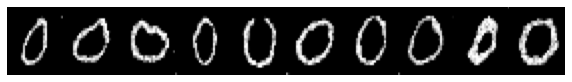

Sampling class: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.98it/s]


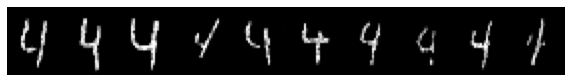

Sampling class: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.98it/s]


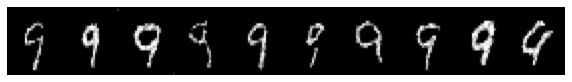

In [29]:
linear_samples_049 = generate_linear_samples(
    linear_model_049, classes_049,
    save_stem=os.path.join(figure_dir, "linear_049_digits")
)

In [30]:
linear_model_0497 = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat,
    os.path.join(models_base_path, "mnist_continuous_class_extension_multistep/4/last_ckpt.pth")
).to(DEVICE)

fine_tune_linear_model(linear_model_0497, classes_0497, data_loader_7, 10)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "5"
Loss: 39.65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.99it/s]


Epoch 1 average Loss: 114.29


Loss: 30.14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.19it/s]


Epoch 2 average Loss: 34.48


Loss: 27.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.82it/s]


Epoch 3 average Loss: 31.80


Loss: 32.41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.73it/s]


Epoch 4 average Loss: 33.78


Loss: 27.11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.78it/s]


Epoch 5 average Loss: 34.54


Loss: 34.01: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.68it/s]


Epoch 6 average Loss: 33.72


Loss: 32.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 35.30it/s]


Epoch 7 average Loss: 34.33


Loss: 37.09: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.69it/s]


Epoch 8 average Loss: 31.81


Loss: 26.58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.43it/s]


Epoch 9 average Loss: 32.92


Loss: 26.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 34.73it/s]
INFO - train - Completed after 0:00:15


Epoch 10 average Loss: 31.72


Sampling class: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.98it/s]


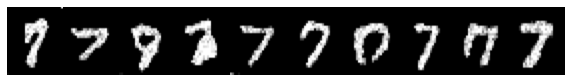

Sampling class: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.95it/s]


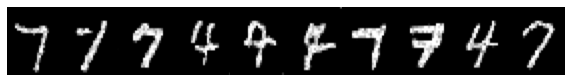

Sampling class: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.93it/s]


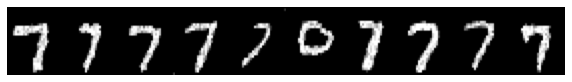

Sampling class: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.93it/s]


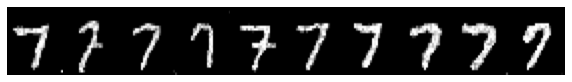

In [31]:
linear_samples_0497 = generate_linear_samples(
    linear_model_0497, classes_0497,
    save_stem=os.path.join(figure_dir, "linear_0497_digits")
)

In [32]:
fine_tune_linear_model(linear_model_0497, classes_04971, data_loader_1, 10)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "6"
Loss: 16.31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 36.84it/s]


Epoch 1 average Loss: 49.15


Loss: 29.27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 36.46it/s]


Epoch 2 average Loss: 25.27


Loss: 22.93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 35.11it/s]


Epoch 3 average Loss: 23.37


Loss: 17.99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 36.06it/s]


Epoch 4 average Loss: 24.41


Loss: 27.57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 36.32it/s]


Epoch 5 average Loss: 23.58


Loss: 19.33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 35.06it/s]


Epoch 6 average Loss: 23.93


Loss: 24.35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 35.55it/s]


Epoch 7 average Loss: 24.49


Loss: 19.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 36.66it/s]


Epoch 8 average Loss: 23.20


Loss: 15.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 35.78it/s]


Epoch 9 average Loss: 23.32


Loss: 28.11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 35.00it/s]
INFO - train - Completed after 0:00:15


Epoch 10 average Loss: 25.09


Sampling class: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.88it/s]


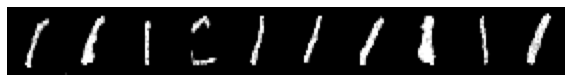

Sampling class: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.87it/s]


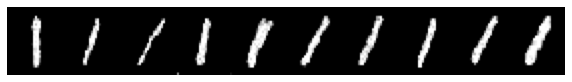

Sampling class: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.87it/s]


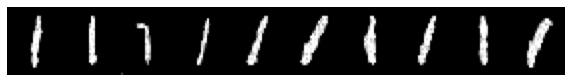

Sampling class: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.87it/s]


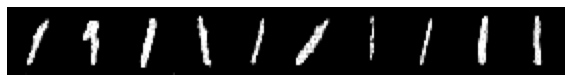

Sampling class: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.87it/s]


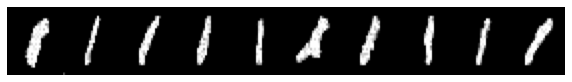

In [33]:
linear_samples_04971 = generate_linear_samples(
    linear_model_0497, classes_04971,
    save_stem=os.path.join(figure_dir, "linear_04971_digits")
)

In [34]:
fine_tune_linear_model(linear_model_0497, classes_049712, data_loader_2, 10)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "7"
Loss: 40.04: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.38it/s]


Epoch 1 average Loss: 61.69


Loss: 34.06: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 34.12it/s]


Epoch 2 average Loss: 38.78


Loss: 48.22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 34.06it/s]


Epoch 3 average Loss: 37.28


Loss: 33.87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.51it/s]


Epoch 4 average Loss: 36.57


Loss: 37.96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.71it/s]


Epoch 5 average Loss: 38.08


Loss: 23.99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 34.56it/s]


Epoch 6 average Loss: 36.49


Loss: 33.21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 34.69it/s]


Epoch 7 average Loss: 37.22


Loss: 48.89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 34.05it/s]


Epoch 8 average Loss: 39.85


Loss: 37.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.49it/s]


Epoch 9 average Loss: 36.17


Loss: 42.48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.64it/s]
INFO - train - Completed after 0:00:14


Epoch 10 average Loss: 36.69


Sampling class: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.87it/s]


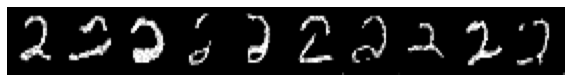

Sampling class: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.86it/s]


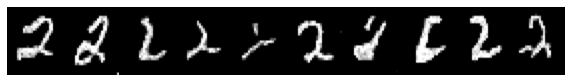

Sampling class: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.85it/s]


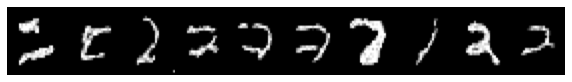

Sampling class: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.85it/s]


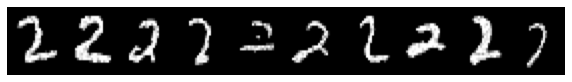

Sampling class: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.83it/s]


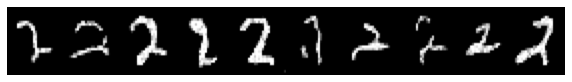

Sampling class: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.84it/s]


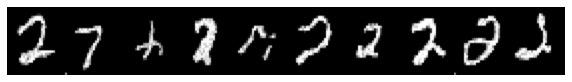

In [35]:
linear_samples_049712 = generate_linear_samples(
    linear_model_0497, classes_049712,
    save_stem=os.path.join(figure_dir, "linear_049712_digits")
)

#### Train label-guided model with all data

In [37]:
linear_model_049712_all = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat,
    os.path.join(models_base_path, "mnist_continuous_class_extension_multistep/4/last_ckpt.pth")
).to(DEVICE)

fine_tune_linear_model(linear_model_049712_all, classes_049712, data_loader_049712, 30)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "9"
Loss: 27.28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 52.17it/s]


Epoch 1 average Loss: 37.08


Loss: 35.44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 52.97it/s]


Epoch 2 average Loss: 34.49


Loss: 28.32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 54.34it/s]


Epoch 3 average Loss: 33.37


Loss: 39.28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.89it/s]


Epoch 4 average Loss: 33.23


Loss: 23.59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.32it/s]


Epoch 5 average Loss: 33.13


Loss: 20.76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.92it/s]


Epoch 6 average Loss: 32.64


Loss: 36.78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.82it/s]


Epoch 7 average Loss: 32.41


Loss: 30.86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 54.42it/s]


Epoch 8 average Loss: 32.10


Loss: 24.65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 54.61it/s]


Epoch 9 average Loss: 32.04


Loss: 22.81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.81it/s]


Epoch 10 average Loss: 32.15


Loss: 29.35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.76it/s]


Epoch 11 average Loss: 31.38


Loss: 22.21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.53it/s]


Epoch 12 average Loss: 31.57


Loss: 20.68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 54.08it/s]


Epoch 13 average Loss: 31.44


Loss: 28.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 52.75it/s]


Epoch 14 average Loss: 30.65


Loss: 25.78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.03it/s]


Epoch 15 average Loss: 30.82


Loss: 17.97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.65it/s]


Epoch 16 average Loss: 30.87


Loss: 40.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.38it/s]


Epoch 17 average Loss: 30.51


Loss: 27.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.47it/s]


Epoch 18 average Loss: 30.40


Loss: 23.75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.77it/s]


Epoch 19 average Loss: 30.23


Loss: 38.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.66it/s]


Epoch 20 average Loss: 30.94


Loss: 27.42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.92it/s]


Epoch 21 average Loss: 30.51


Loss: 30.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.50it/s]


Epoch 22 average Loss: 29.63


Loss: 28.63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.52it/s]


Epoch 23 average Loss: 30.02


Loss: 38.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.86it/s]


Epoch 24 average Loss: 30.47


Loss: 28.38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.67it/s]


Epoch 25 average Loss: 30.01


Loss: 31.29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 54.07it/s]


Epoch 26 average Loss: 29.62


Loss: 49.94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.24it/s]


Epoch 27 average Loss: 29.36


Loss: 25.94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.67it/s]


Epoch 28 average Loss: 29.51


Loss: 39.33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.79it/s]


Epoch 29 average Loss: 29.75


Loss: 27.47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:05<00:00, 53.69it/s]
INFO - train - Completed after 0:02:42


Epoch 30 average Loss: 29.87


Sampling class: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.87it/s]


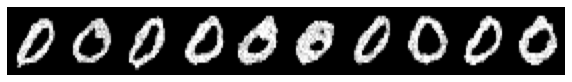

Sampling class: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.87it/s]


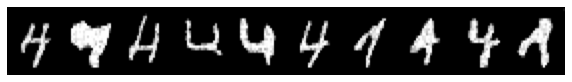

Sampling class: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.86it/s]


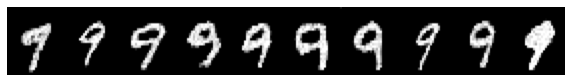

Sampling class: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.85it/s]


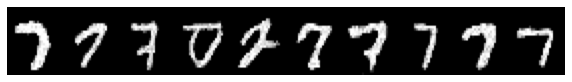

Sampling class: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.84it/s]


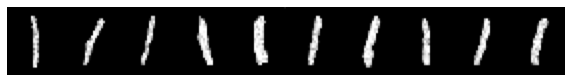

Sampling class: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.83it/s]


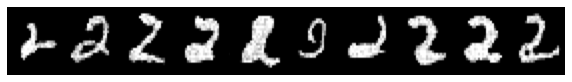

In [38]:
linear_samples_049712_all = generate_linear_samples(
    linear_model_049712_all, classes_049712,
    save_stem=os.path.join(figure_dir, "linear_049712_all_digits")
)

**Compute FIDs**

In [39]:
# Sample digits from the original dataset
true_samples = {}
for class_to_sample in classes_049712:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(data_loader_049712.dataset.targets == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=1000, replace=False)
    samples = ((data_loader_049712.dataset.data[sample_inds] / 256 * 2) - 1).cpu().numpy()[:, None]
    true_samples[class_to_sample] = samples

Sampling class: 0
Sampling class: 4
Sampling class: 9
Sampling class: 7
Sampling class: 1
Sampling class: 2


In [40]:
def compute_fids(samples):
    fids = {}
    for c in samples.keys():
        fids[c] = fid.compute_fid(samples[c], true_samples[c])
    return fids

In [41]:
branched_fids_049 = compute_fids(branched_samples_049)
branched_fids_0497 = compute_fids(branched_samples_0497)
branched_fids_04971 = compute_fids(branched_samples_04971)
branched_fids_049712 = compute_fids(branched_samples_049712)
linear_fids_049 = compute_fids(linear_samples_049)
linear_fids_0497 = compute_fids(linear_samples_0497)
linear_fids_04971 = compute_fids(linear_samples_04971)
linear_fids_049712 = compute_fids(linear_samples_049712)
linear_fids_049712_all = compute_fids(linear_samples_049712_all)

In [42]:
# print(branched_before_fids)
# print(branched_after_fids)
# print(linear_before_fids)
# print(linear_after_newonly_fids)
# print(linear_after_all_fids)
# {0: 23.11633549064858, 4: 17.554127554182706, 9: 19.168488612087437}
# {0: 26.994116150415692, 4: 18.230416480830353, 9: 20.033732091018226, 7: 22.96911094572033}
# {0: 40.60493446096415, 4: 40.21296005710471, 9: 46.26767416821082, 7: 295.82348278085703}
# {0: 224.12945034383986, 4: 104.85626479406496, 9: 99.43909776120395, 7: 29.853624615418624}
# {0: 50.39232930384999, 4: 37.86158194936105, 9: 32.856277798307495, 7: 21.466374130747468}

print("Branched")
print(branched_fids_049)
print(branched_fids_0497)
print(branched_fids_04971)
print(branched_fids_049712)
print("Linear")
print(linear_fids_049)
print(linear_fids_0497)
print(linear_fids_04971)
print(linear_fids_049712)
print(linear_fids_049712_all)

Branched
{0: 24.019495673802254, 4: 16.48023446654044, 9: 21.07560697329494}
{0: 22.204811241282314, 4: 15.627515382973709, 9: 22.318379026661944, 7: 20.94648643897001}
{0: 23.690431721552493, 4: 16.315359106703283, 9: 21.480749040697717, 7: 23.44602121813678, 1: 21.823942776296946}
{0: 24.097009105056273, 4: 16.232983174154555, 9: 20.69614828713485, 7: 21.4528489136165, 1: 21.613604717358278, 2: 40.85283074759886}
Linear
{0: 40.2096011685821, 4: 53.07838853288788, 9: 39.96336273350425}
{0: 248.61046883114716, 4: 126.63837050865169, 9: 128.00159704662707, 7: 33.75397500033714}
{0: 391.80467126159346, 4: 253.98611262949078, 9: 245.20418499861418, 7: 255.65868038057266, 1: 28.712126496977614}
{0: 223.41258098768418, 4: 169.9297493019542, 9: 138.59413438618418, 7: 184.04181667572044, 1: 216.12108945759155, 2: 37.381028723019554}
{0: 63.1137483991634, 4: 43.70377313823665, 9: 46.73660368143305, 7: 51.65227852233008, 1: 20.0889386681877, 2: 60.14226836088523}


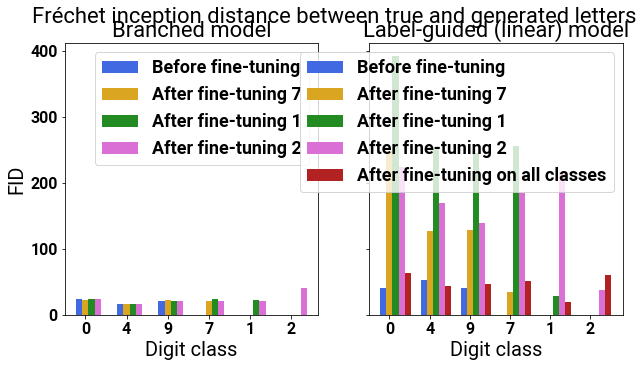

In [44]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

bar_width = 0.15
x = np.arange(len(branched_fids_049712))

ax[0].bar(
    x, [branched_fids_049[c] for c in classes_049] + [0, 0, 0], bar_width, label="Before fine-tuning", color="royalblue"
)
ax[0].bar(
    x + bar_width, [branched_fids_0497[c] for c in classes_0497] + [0, 0], bar_width, label="After fine-tuning 7", color="goldenrod"
)
ax[0].bar(
    x + (2 * bar_width), [branched_fids_04971[c] for c in classes_04971] + [0], bar_width, label="After fine-tuning 1", color="forestgreen"
)
ax[0].bar(
    x + (3 * bar_width), [branched_fids_049712[c] for c in classes_049712], bar_width, label="After fine-tuning 2", color="orchid"
)
ax[0].set_title("Branched model")

ax[1].bar(
    x, [linear_fids_049[c] for c in classes_049] + [0, 0, 0], bar_width, label="Before fine-tuning", color="royalblue"
)
ax[1].bar(
    x + bar_width, [linear_fids_0497[c] for c in classes_0497] + [0, 0], bar_width, label="After fine-tuning 7", color="goldenrod"
)
ax[1].bar(
    x + (2 * bar_width), [linear_fids_04971[c] for c in classes_04971] + [0], bar_width, label="After fine-tuning 1", color="forestgreen"
)
ax[1].bar(
    x + (3 * bar_width), [linear_fids_049712[c] for c in classes_049712], bar_width, label="After fine-tuning 2", color="orchid"
)
ax[1].bar(
    x + (4 * bar_width), [linear_fids_049712_all[c] for c in classes_049712], bar_width, label="After fine-tuning on all classes", color="firebrick"
)
ax[1].set_title("Label-guided (linear) model")
for i in range(2):
    ax[i].set_xticks(x + bar_width, labels=[c for c in classes_049712])
    ax[i].set_xlabel("Digit class")
    ax[i].legend()
ax[0].set_ylabel("FID")
fig.suptitle("Fréchet inception distance between true and generated letters")
fig.savefig(
    os.path.join(figure_dir, "digit_fid.svg"),
    format="svg"
)
plt.show()